# Checkpoint 1

Implement here your algorithm to interpolate/extrapolate the activation time field from timings recorded in the 20 electrodes of the mapping catheter. 

The algorithm should output the following information:
- a reconstruction of the activation times evaluated at each point of a structured grid on the square (-1.5, 1.5)x(-1.5, 1.5), 
- an approximation of the conduction velocity (a clinical biomarker) evaluated at each point of a structured grid on the same square.


In [33]:
# imports

import numpy as np
import matplotlib.pyplot as plt



In [34]:

# loading of the dataset

CP1data = np.load("CP1data.npz")
CP1data = CP1data['arr_0']

In [35]:
print(CP1data.shape)
print(CP1data[0][1])

type(CP1data)

(100, 3, 20)
[ 0.     0.496  0.354 -0.322 -0.316  0.     0.694  0.496 -0.45  -0.442
  0.     1.288  0.922 -0.836 -0.822  0.     1.486  1.064 -0.964 -0.948]


numpy.ndarray

# Display one recording

In [36]:
ind_disp = 63
x_meas = CP1data[ind_disp][0]
y_meas = CP1data[ind_disp][1]
t_meas = CP1data[ind_disp][2]


In [37]:
x = CP1data[:,0]
y = CP1data[:,1]
coord = np.vstack((x.flatten(), y.flatten())).T
unique_coord, counts = np.unique(coord,axis=0,return_counts=True)


[[0.5 0. ]
 [0.7 0. ]
 [1.3 0. ]
 [1.5 0. ]]


This shows that for the same position over different measurements there are different times values, so probably the measurements are related to different patiences.
All the measurements have 4 coordinates in common (on correspondence of y=0)

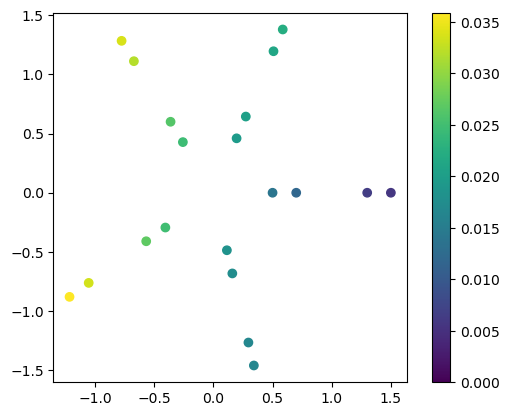

In [38]:
# Display a sample

plt.figure(1)
plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(t_meas) )
plt.gca().set_aspect(1)
plt.colorbar()

## Model Formulation 

### First try: Gaussian Processes

In [39]:
# Try with a gaussian process -> one process for every measurement and then take the mean

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF
import warnings

# Split dataset in training and validation

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [40]:
# Hyperparameter tuning -> don't run 

# n_split = 10

# KF = KFold(n_splits=n_split,shuffle=True)

# # Tune hyperparameters of GP varying on kernels and their parameters using CV mse as metric

# ls_values = np.linspace(0.1,2,20) ## set a better range
# err = np.zeros((len(ls_values),2))

# for il,l in enumerate(ls_values):

#     kernels = [Matern(length_scale=l),RBF(length_scale=l)]

#     for ik,k in enumerate(kernels):

#         train_models = []
#         err_k = []

#         idx = list(KF.split(CP1data))

#         # Iterate over all the partitions to compute cross validation error
#         for n in range(n_split):

#             for i in idx[n][0]:
#                 x_meas = CP1data[i][0]
#                 y_meas = CP1data[i][1]
#                 t_meas = CP1data[i][2]

#                 x = np.array([x_meas,y_meas]).transpose()
#                 y = np.array(t_meas)
#                 model = GaussianProcessRegressor(kernel=k)
#                 model.fit(x,y)
#                 train_models.append(model)

#             err_kpart = []
            
#             for j in idx[n][1]:
#                 # Compute error on validation -> our model is the mean of all the gaussian processes fitted on the training measurements
#                 x_meas = CP1data[j][0]
#                 y_meas = CP1data[j][1]
#                 t_meas = CP1data[j][2]
#                 coord = np.vstack((x_meas.flatten(), y_meas.flatten())).T
#                 with warnings.catch_warnings():
#                     warnings.simplefilter("ignore")
#                     means = [m.predict(coord) for m in train_models]
#                 t_hat = np.mean(np.array(means),axis=0)
#                 err_kpart.append(mean_squared_error(t_meas,t_hat))
            
#             err_k.append(np.mean(err_kpart))
        
#         err[il,ik] = np.mean(err_k)

# best_idx = np.argwhere(err==np.min(err))[0]
# best_ls = ls_values[best_idx[0]]

# if best_idx[1] == 0:
#     best_kernel = Matern(length_scale=best_ls)
# else:
#     best_kernel = RBF(length_scale=best_ls)

# print(best_kernel)

# best_kernel: Matern with ls=1.2


In [41]:
# Fit again the model with best hyperparameters
#np.random.seed(7549)

train_models = []
# best kernel 
best_kernel = Matern(length_scale=1.2)
# Train over all available dataset
idx = np.random.choice(100,1)

# Fit the gaussian process on a random measurement

for i in idx:
        x_meas = CP1data[i][0]
        y_meas = CP1data[i][1]
        t_meas = CP1data[i][2]

        x = np.array([x_meas,y_meas]).transpose()
        y = np.array(t_meas)
        model = GaussianProcessRegressor(kernel=best_kernel)
        model.fit(x,y)
        train_models.append(model)



In [42]:
def retrieve_coord_from_grid(x,y,X,Y,vel):

    coord = np.zeros((2,20),dtype=int)
    samples = np.zeros((3,20))

    for k,p in enumerate(zip(x,y)):
        
        coord[0,k] = np.where(X==p[0])[1][0]
        coord[1,k] = np.where(Y==p[1])[0][0]

        samples[0,k] = p[0]
        samples[1,k] = p[1]
        samples[2,k] = vel[coord[0,k],coord[1,k]]

    return samples

In [43]:
def generate_samples(X, Y, vel_pred, num_samples=100):
    """
    Generate samples from given X, Y, and vel_pred arrays.

    Parameters:
        X (array_like): 1D array of X coordinates.
        Y (array_like): 1D array of Y coordinates.
        vel_pred (array_like): 1D array of predicted velocities.
        num_samples (int): Number of samples to generate.

    Returns:
        samples (numpy.ndarray): Array of shape (num_samples, 3, 20) containing random triplets of (X, Y, velocity).
    """
    samples = np.zeros((num_samples, 3, 20))


    for i in range(num_samples):
        random_indices1 = np.random.choice(len(X), size=20, replace=False)
        random_indices2 = np.random.choice(len(X), size=20, replace=False)

        for j in range(20):
            samples[i, 0, j] = X[random_indices1[j]][random_indices2[j]]
            samples[i, 1, j] = Y[random_indices1[j]][random_indices2[j]]
            samples[i, 2, j] = vel_pred[random_indices1[j]][random_indices2[j]]


    return samples

# signature of the function

def checkpoint1_solution( x, y , t, X , Y ):

return time_pred,vel_pred



In [44]:
from scipy.interpolate import griddata

X, Y = np.meshgrid(np.linspace(-1.5,1.5,1501), np.linspace(-1.5,1.5,1501))

def checkpoint1_solution( x, y , t, X , Y ):
    
    # time_pred = griddata(list(zip(x, y)), t, (X, Y), method='nearest')
    x = np.array([x,y]).transpose()
    y = np.array(t)

    model = GaussianProcessRegressor(kernel=Matern(length_scale=1.2))
    model.fit(x,y)
    
    # coordinates of the grid
    coord = np.vstack((X.flatten(), Y.flatten())).T

    # prediction of the mean of every GP on the full grid
    #means_GPs = [m.predict(coord) for m in train_models]
    # estimate in the mean over all the GPs
    #time_pred = np.mean(means_GPs,axis=0).reshape(X.shape)
    
    time_pred = model.predict(coord).reshape(X.shape)

    # computation of the gradient
    grad_AT = np.gradient(time_pred)

    vel_pred = 1.0/( np.sqrt((grad_AT[0]/(3.0/1500))**2+(grad_AT[1]/(3.0/1500))**2) + 1e-4 )

    #samples = retrieve_coord_from_grid(x[:,0],x[:,1],X,Y,vel_pred)

    # np.random.seed(7549)

    ## create some samples of velocities (20 triplets (x, y, v) per sample)

    # how to sample velocity -> values corresponding to the input coordinates plus few points close to the starting point -> TODO
    # try to get two points close to x = 1.5, one over y = 0 and the other one below

    # x_sample = X[0,-5]
    # y_sample1 = -1.0
    # y_sample2 = 1.0

    # #print(np.where(X==x_sample))

    # #a = vel_pred[int(np.where(X==x_sample)[1][0]),int(np.where(Y==y_sample1)[0][0])]
    
    # new_samples = np.array([[x_sample,y_sample1,vel_pred[np.where(X==x_sample)[1][0],np.where(Y==y_sample1)[0][0]]],[x_sample,y_sample2,vel_pred[np.where(X==x_sample)[1][0],np.where(Y==y_sample2)[0][0]]]]).reshape((3,2))
    # samples = np.concatenate([samples,new_samples],axis=1)
    # print(samples)
    samples = np.zeros((5, 3, 50))


    for i in range(5):
        random_indices1 = np.random.choice(len(X), size=50, replace=False)
        random_indices2 = np.random.choice(len(X), size=50, replace=False)

        for j in range(50):
            samples[i, 0, j] = X[random_indices1[j]][random_indices2[j]]
            samples[i, 1, j] = Y[random_indices1[j]][random_indices2[j]]
            samples[i, 2, j] = vel_pred[random_indices1[j]][random_indices2[j]]

    # best kernel 
    best_kernel = Matern(length_scale=1.2)
    # Train over all available dataset
    
    # idx = 0
    
    # x_meas = samples[idx][0]
    # y_meas = samples[idx][1]
    # vel_pred_prior = samples[idx][2]

    # x = np.array([x_meas,y_meas]).transpose()
    # y = np.array(vel_pred_prior)
    # model = GaussianProcessRegressor(kernel=best_kernel)
    # model.fit(x,vel_pred_prior)
    # vel_pred = model.predict(coord).reshape(X.shape)

    # x_meas = samples[0]
    # y_meas = samples[1]
    # vel_pred_prior = samples[2]

    # x = np.array([x_meas,y_meas]).transpose()
    # y = np.array(vel_pred_prior)
    # model = GaussianProcessRegressor(kernel=best_kernel)
    # model.fit(x,vel_pred_prior)
    # vel_pred = model.predict(coord).reshape(X.shape)

    #fit model on these samples: mother kernel, with lenghtscale = 1.2 (same as time) found after training 
    ## samples diversi danno risulati diversi (5 samples max a 122. 30 samples a 130, massimi piu' bassi si ottengono invece mettendo 30 triplette)
    ### secondo me invece dagli un solo random sample non ha molto senso perche' ogni volta da' risulati diversi (vedi prte commentata qui sopra)

    train_models = []

    for i in range(5):
            x_meas = samples[i][0]
            y_meas = samples[i][1]
            vel_pred_prior = samples[i][2]

            x = np.array([x_meas,y_meas]).transpose()
            y = np.array(vel_pred_prior)
            model = GaussianProcessRegressor(kernel=best_kernel)
            model.fit(x,vel_pred_prior)
            train_models.append(model)

    # prediction of the mean of every GP on the full grid
    means_GPs = [m.predict(coord) for m in train_models]
    # estimate in the mean over all the GPs
    vel_pred = np.mean(means_GPs,axis=0).reshape(X.shape) 


    # max_found = np.max(vel_pred)

    # print(max_found)

    # threshold = 110 #np.percentile(vel_pred.flatten(), 95)
    # print(threshold)

    # max_found = np.max(vel_pred)

    # print(max_found)

    # # Calcola il fattore di scala per ridimensionare tutti i valori
    # scaling_factor = threshold / max_found

    # # Ridimensiona tutti i valori nell'array utilizzando il fattore di scala
    # vel_pred = vel_pred * scaling_factor  

    # max_found = np.max(vel_pred)

    # print(max_found)


    # threshold = np.percentile(vel_pred.flatten(), 95)
    # print(threshold)

    # vel_pred = (vel_pred>threshold)*threshold + (vel_pred<threshold)*vel_pred

    return time_pred,vel_pred


time_pred,vel_pred = checkpoint1_solution( x_meas, y_meas , t_meas, X , Y )




(0.0, 0.06)

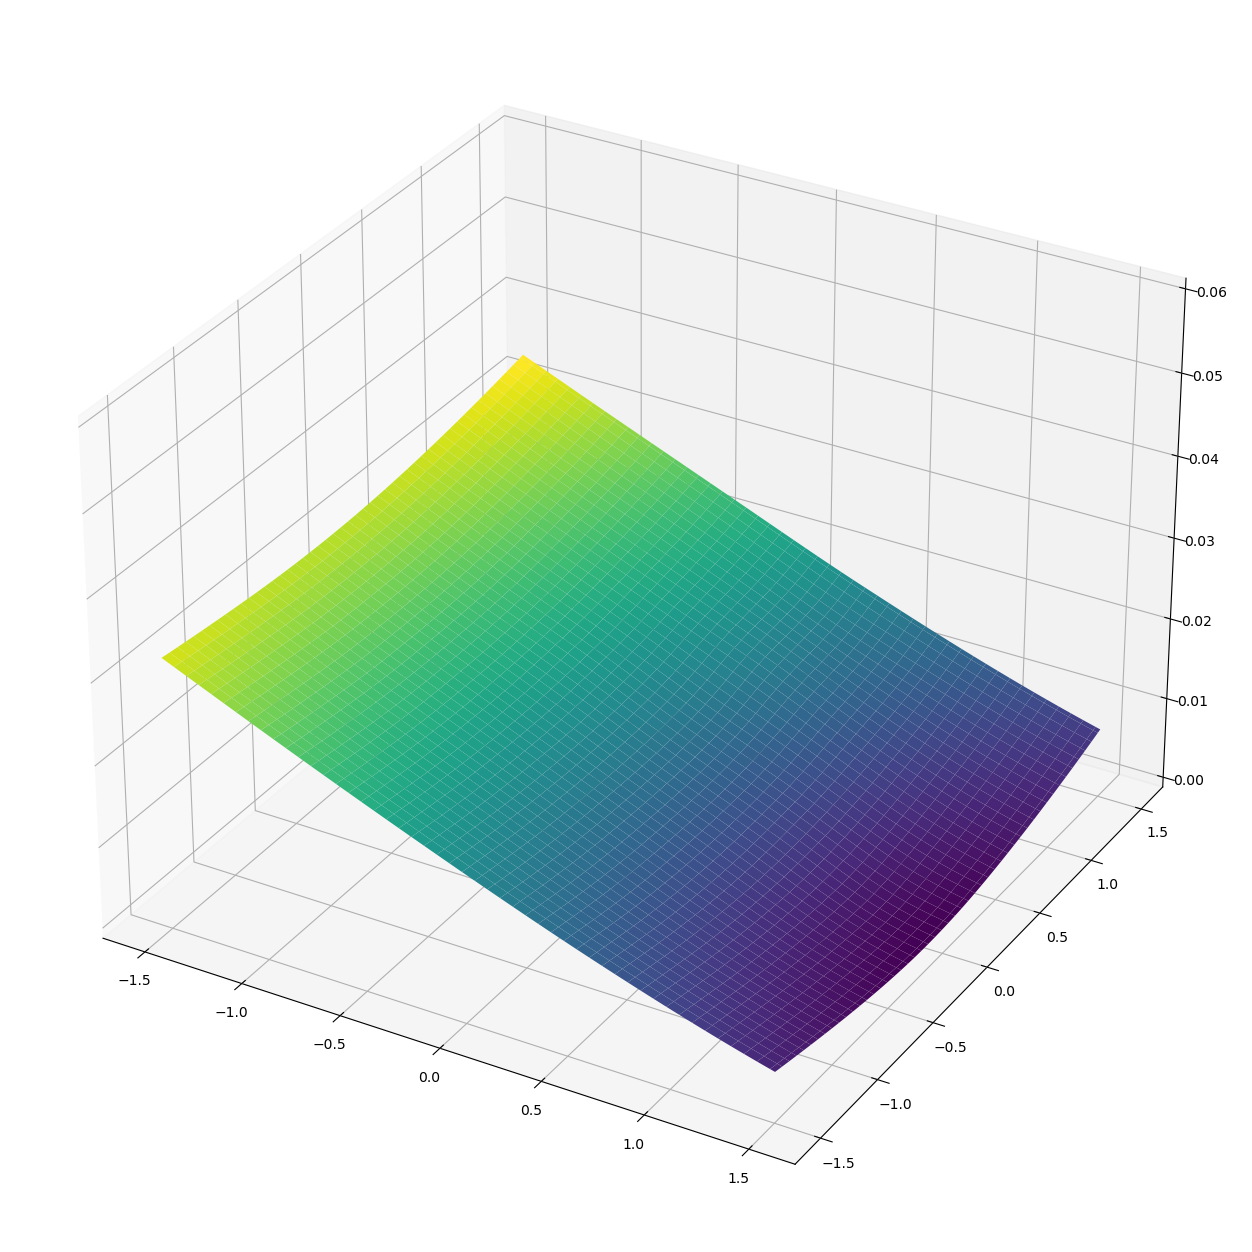

In [45]:
from matplotlib import cm

my_col = cm.jet(time_pred/np.max(time_pred))
fig, ax = plt.subplots(figsize = (20,16), subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,time_pred,cmap='viridis', edgecolor='none')
ax.axes.set_zlim3d(bottom=0, top=0.06)

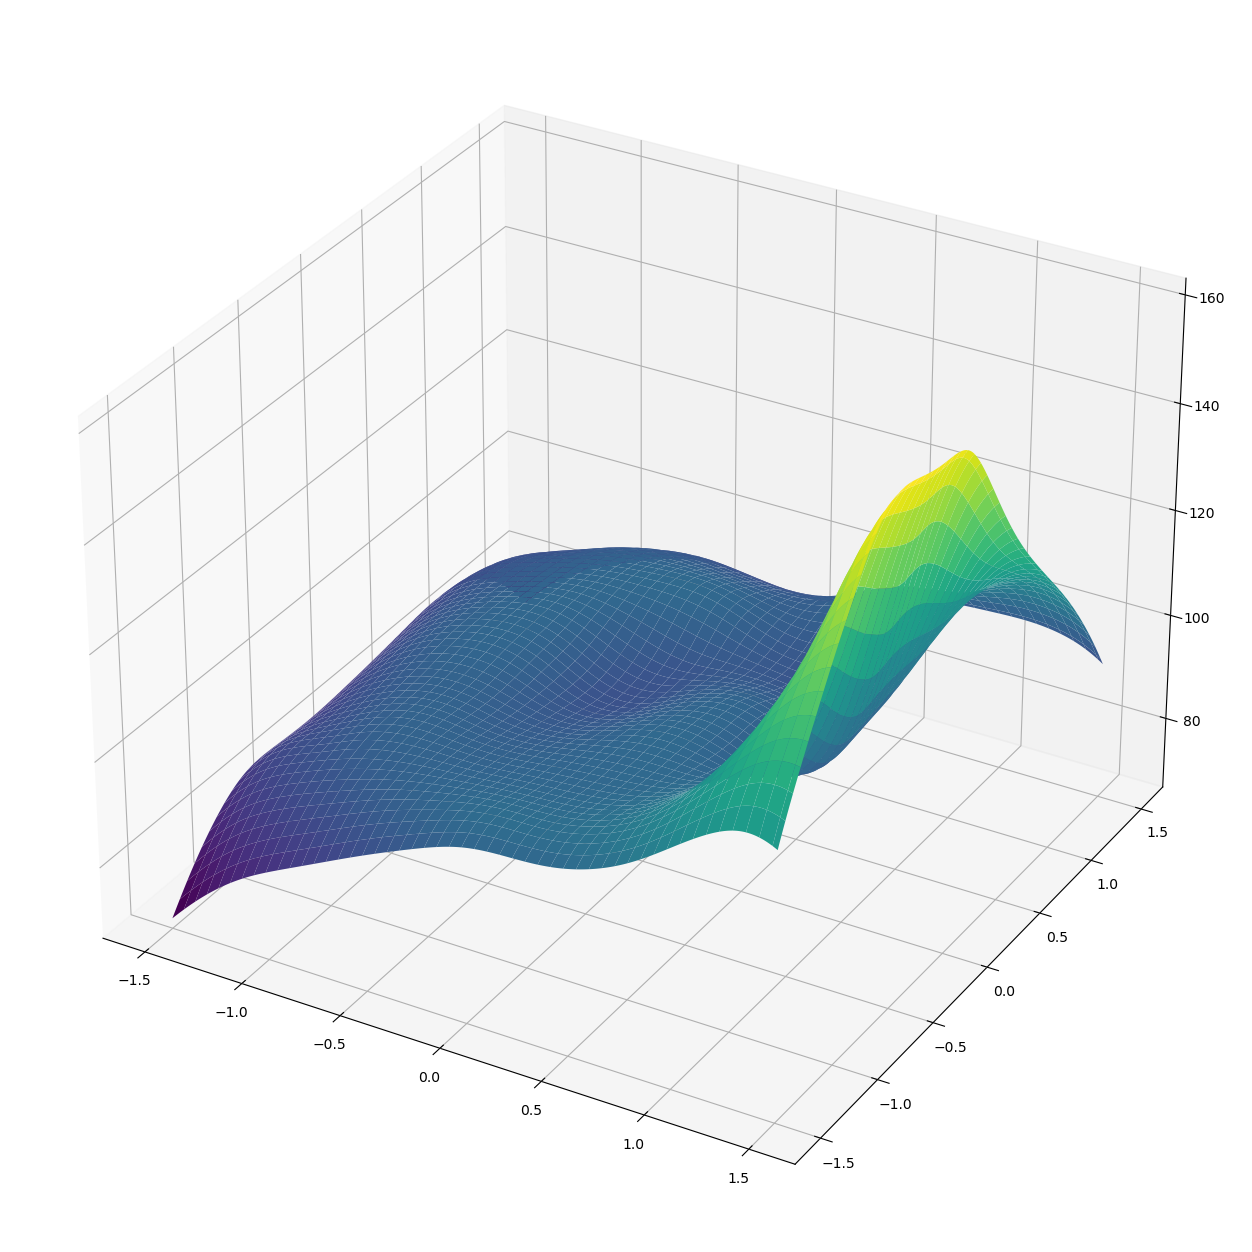

In [46]:
my_col_grad = cm.jet(vel_pred/np.amax(vel_pred))
fig, ax = plt.subplots(figsize = (20,16), subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,vel_pred,cmap='viridis', edgecolor='none')



In [47]:
"""# Hyperparameter tuning

### questa parte l'ho eseguita una volta su un array (100, 3, 20) costruito una volta per tutte con un campo di velocita' predette.

samples = generate_samples(X, Y, vel_pred, num_samples=100)
n_split = 10

KF = KFold(n_splits=n_split, shuffle=True)

# Tune hyperparameters of GP varying on kernels and their parameters using CV mse as metric

ls_values = np.linspace(0.1, 2, 20)  # Set a better range
err = np.zeros((len(ls_values), 2))

for il, l in enumerate(ls_values):

    kernels = [Matern(length_scale=l), RBF(length_scale=l)]

    for ik, k in enumerate(kernels):

        train_models = []
        err_k = []

        idx = list(KF.split(samples))

        # Iterate over all the partitions to compute cross validation error
        for n in range(n_split):

            for i in idx[n][0]:
                x_meas = samples[i][0]
                y_meas = samples[i][1]
                t_meas = samples[i][2]

                x = np.array([x_meas, y_meas]).transpose()
                y = np.array(t_meas)
                model = GaussianProcessRegressor(kernel=k)
                model.fit(x, y)
                train_models.append(model)

            err_kpart = []

            for j in idx[n][1]:
                # Compute error on validation -> our model is the mean of all the gaussian processes fitted on the training measurements
                x_meas = samples[j][0]
                y_meas = samples[j][1]
                t_meas = samples[j][2]
                coord = np.vstack((x_meas.flatten(), y_meas.flatten())).T
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    means = [m.predict(coord) for m in train_models]
                t_hat = np.mean(np.array(means), axis=0)
                err_kpart.append(mean_squared_error(t_meas, t_hat))

            err_k.append(np.mean(err_kpart))

        err[il, ik] = np.mean(err_k)

best_idx = np.argwhere(err == np.min(err))[0]
best_ls = ls_values[best_idx[0]]

if best_idx[1] == 0:
    best_kernel = Matern(length_scale=best_ls)
else:
    best_kernel = RBF(length_scale=best_ls)

print(best_kernel)"""





'# Hyperparameter tuning\n\n### questa parte l\'ho eseguita una volta su un array (100, 3, 20) costruito una volta per tutte con un campo di velocita\' predette.\n\nsamples = generate_samples(X, Y, vel_pred, num_samples=100)\nn_split = 10\n\nKF = KFold(n_splits=n_split, shuffle=True)\n\n# Tune hyperparameters of GP varying on kernels and their parameters using CV mse as metric\n\nls_values = np.linspace(0.1, 2, 20)  # Set a better range\nerr = np.zeros((len(ls_values), 2))\n\nfor il, l in enumerate(ls_values):\n\n    kernels = [Matern(length_scale=l), RBF(length_scale=l)]\n\n    for ik, k in enumerate(kernels):\n\n        train_models = []\n        err_k = []\n\n        idx = list(KF.split(samples))\n\n        # Iterate over all the partitions to compute cross validation error\n        for n in range(n_split):\n\n            for i in idx[n][0]:\n                x_meas = samples[i][0]\n                y_meas = samples[i][1]\n                t_meas = samples[i][2]\n\n                x = 